In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',0)
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam, RMSprop,Adamax
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
# Loading the training set
train_ds = np.load('/kaggle/input/ift3395-6390-quickdraw/train.npz')
train_x = train_ds['arr_0']
train_y = train_ds['arr_1']

train_x.shape, train_y.shape

((1500, 784), (1500,))

In [29]:
#Loading the test data
test_ds = np.load('/kaggle/input/ift3395-6390-quickdraw/test.npz')
test_x = test_ds['arr_0']

test_x.shape

(60000, 784)

In [5]:
# Normalizing the values, so that the algorithm will converge faster
train_x=train_x/255.0

In [6]:
# doing one hot encoding to the output 
n_classes = 6
train_y = np_utils.to_categorical(train_y, n_classes)
print("After one-hot encoding: ", train_y.shape)

After one-hot encoding:  (1500, 6)


In [7]:
#Reshaping it as a image
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)


In [8]:
from sklearn.model_selection import train_test_split

X_train,X_validation,y_train,y_validation=train_test_split(train_x, train_y , test_size=0.2)

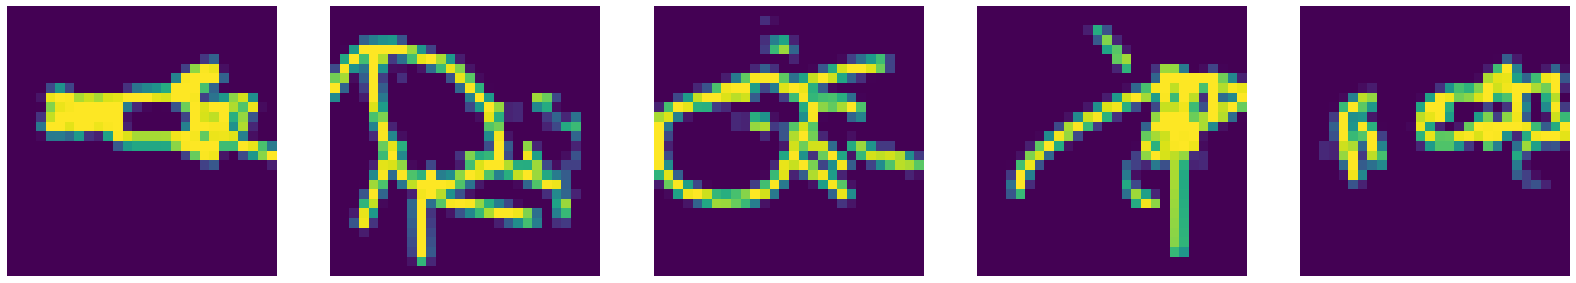

In [9]:
# you can pass the parameters here and check how the images are
datagen = ImageDataGenerator(fill_mode='nearest')

# fit parameters from data
datagen.fit(X_train)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(28,28))

# plt.imshow(train_x[111].reshape(28, 28))
# plt.show()
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 5):
        
        ax[i].imshow(X_batch[i].reshape(28,28))
        ax[i].axis('off')
    break

In [10]:
datagen = ImageDataGenerator(rotation_range=45, width_shift_range=.2, 
                             height_shift_range=.2,vertical_flip=True,
                             fill_mode='nearest',horizontal_flip=True,zoom_range=0.2,shear_range = 0.2 )

# fit parameters from data
datagen.fit(X_train)

In [11]:

def get_model(opt,activation,dropout,lr):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=activation, input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2,2) , strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activation, ))
    model.add(MaxPool2D(pool_size=(1,1)))

    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation=activation, ))
    model.add(MaxPool2D(pool_size=(1,1)))
    
#     model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation=activation, ))
#     model.add(MaxPool2D(pool_size=(1,1)))

    # flatten output of conv
    model.add(Flatten())
    # hidden layer
    model.add(Dense(512, activation=activation))
    model.add(Dropout(dropout))

    model.add(Dense(256, activation=activation))
    model.add(Dropout(dropout))

    model.add(Dense(6, activation='softmax'))
    # compiling the sequential model
    if opt == 'adam':
        optimizer = Adam(lr=lr)
    elif opt == 'adamax':
        optimizer = Adamax(lr=lr)
    elif opt == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return model

In [12]:
def train_evaluate(parameterization):
    acc = 0
    batch_size=32
    mymodel = get_model(opt=parameterization["opt"],activation=parameterization["activation"], dropout=parameterization["dropout"], lr=parameterization["lr"])
    mymodel.fit_generator(datagen.flow(X_train, y_train), epochs=100, verbose=0)
    acc = mymodel.evaluate(X_validation, y_validation)[1]
    print(parameterization, acc)
    del mymodel
    return acc

In [13]:
!pip3 install ax-platform

     |████████████████████████████████| 675 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 327 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 6.4 MB/s eta 0:00:01
  Created wheel for gpytorch: filename=gpytorch-1.2.1-py2.py3-none-any.whl size=463973 sha256=2884514c7810dea342702c7aa65a85a5c39d4c3db1eaa9318b850ce7ba2e0421
  Stored in directory: /root/.cache/pip/wheels/5f/2f/85/fa26b1b3b26cb1010a00841a49d387a3f8b8dacb11d1301826
Successfully built gpytorch


In [15]:
from ax.service.managed_loop import optimize
best_parameters, values, experiment, model = optimize(
     parameters=[
                 {"name": "opt", "type": "choice", "values": ['adam', 'adamax','rmsprop']},
                 {"name": "activation", "type": "choice", "values": ['relu', 'tanh']},
                 {"name": "dropout", "type": "choice", "values": [0.0, 0.25, 0.50, 0.75, 0.99]},
#                  {"name": "batch_size", "type": "choice", "values": [10, 20, 40, 60, 80, 100] },
#                  {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True}
                 {"name": "lr", "type": "choice", "values": [0.003, 0.03, 0.1, 0.2, 0.3,0.0003] }
                ],
    evaluation_function=train_evaluate,
    objective_name="acc",
     # total trails. Based on the dateset size you can change this value. This value is used to determine the number of exploration and exploitation steps. 
    total_trials=5,
    )

[INFO 11-22 09:29:22] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter opt. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 09:29:22] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter activation. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 09:29:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dropout. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 09:29:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

10/10 [==============================] - 0s 5ms/step - loss: 1.4564 - accuracy: 0.4367


[INFO 11-22 09:30:12] ax.service.managed_loop: Running optimization trial 2...


{'opt': 'adam', 'activation': 'tanh', 'dropout': 0.5, 'lr': 0.003} 0.43666666746139526
10/10 [==============================] - 0s 4ms/step - loss: 1.0972 - accuracy: 0.6267


[INFO 11-22 09:31:01] ax.service.managed_loop: Running optimization trial 3...


{'opt': 'adamax', 'activation': 'relu', 'dropout': 0.75, 'lr': 0.003} 0.6266666650772095
10/10 [==============================] - 0s 3ms/step - loss: 1.7946 - accuracy: 0.1467


[INFO 11-22 09:31:51] ax.service.managed_loop: Running optimization trial 4...


{'opt': 'adamax', 'activation': 'relu', 'dropout': 0.99, 'lr': 0.1} 0.14666666090488434
10/10 [==============================] - 0s 3ms/step - loss: 1.8108 - accuracy: 0.1933


[INFO 11-22 09:32:43] ax.service.managed_loop: Running optimization trial 5...


{'opt': 'rmsprop', 'activation': 'tanh', 'dropout': 0.25, 'lr': 0.0003} 0.19333332777023315
10/10 [==============================] - 0s 3ms/step - loss: 1.7965 - accuracy: 0.1467
{'opt': 'adam', 'activation': 'tanh', 'dropout': 0.99, 'lr': 0.0003} 0.14666666090488434


In [16]:
# Get the best hyper parameters
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df["mean"] == df["mean"].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]

print(best_parameters)
print(best_arm)

{'opt': 'adamax', 'activation': 'relu', 'dropout': 0.75, 'lr': 0.003}
Arm(name='1_0', parameters={'opt': 'adamax', 'activation': 'relu', 'dropout': 0.75, 'lr': 0.003})


In [18]:
#To evaluate on the best parameter
train_evaluate(best_parameters)

10/10 [==============================] - 0s 3ms/step - loss: 1.1534 - accuracy: 0.6167
{'opt': 'adamax', 'activation': 'relu', 'dropout': 0.75, 'lr': 0.003} 0.6166666746139526


0.6166666746139526

In [19]:
# opt,activation,dropout,lr
#('adamax','relu', 0.75,0.01)  out of 30 trails ~70% val accuracy

test_model=get_model('adamax','relu', 0.75,0.01)

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16

# # base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
# # include_top = False, # Leave out the last fully connected layer
# # weights = 'imagenet')



# # model.add(base_model)


# model = Sequential()

# # model.add(base_model)

# model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)))

# model.add(MaxPool2D(pool_size=(2,2) , strides=(2, 2)))

# model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', ))
# model.add(MaxPool2D(pool_size=(1,1)))

# model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', ))
# model.add(MaxPool2D(pool_size=(1,1)))

# model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', ))
# model.add(MaxPool2D(pool_size=(1,1)))

# model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', ))
# model.add(MaxPool2D(pool_size=(1,1)))



# # flatten output of conv
# model.add(Flatten())
# # hidden layer
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))



# # output layer
# model.add(Dense(6, activation='softmax'))
# # compiling the sequential model
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [20]:

batch_size = 32
# Rotate images by 90 degrees

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=.2, 
                             height_shift_range=.2,vertical_flip=True,
                             fill_mode='nearest',horizontal_flip=True,zoom_range=0.1,shear_range = 0.2 )

# fit parameters from data
datagen.fit(X_train)

# training the model for 10 epochs
history = test_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
#                         steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=150,
                        validation_data=(X_validation, y_validation)#,callbacks=[early_stopping] 
                             )
# model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_validation, y_validation))

Epoch 1/150
38/38 [==============================] - 1s 19ms/step - loss: 1.8160 - accuracy: 0.1492 - val_loss: 1.7912 - val_accuracy: 0.1467
Epoch 2/150
38/38 [==============================] - 1s 15ms/step - loss: 1.7927 - accuracy: 0.1642 - val_loss: 1.7911 - val_accuracy: 0.2033
Epoch 3/150
38/38 [==============================] - 1s 15ms/step - loss: 1.7892 - accuracy: 0.1892 - val_loss: 1.7860 - val_accuracy: 0.1700
Epoch 4/150
38/38 [==============================] - 1s 15ms/step - loss: 1.7919 - accuracy: 0.1708 - val_loss: 1.7868 - val_accuracy: 0.2400
Epoch 5/150
38/38 [==============================] - 1s 15ms/step - loss: 1.7900 - accuracy: 0.1842 - val_loss: 1.7821 - val_accuracy: 0.2700
Epoch 6/150
38/38 [==============================] - 1s 14ms/step - loss: 1.7879 - accuracy: 0.1883 - val_loss: 1.7679 - val_accuracy: 0.3400
Epoch 7/150
38/38 [==============================] - 1s 16ms/step - loss: 1.7785 - accuracy: 0.2025 - val_loss: 1.7485 - val_accuracy: 0.3300
Epoch 

38/38 [==============================] - 1s 14ms/step - loss: 1.4559 - accuracy: 0.4283 - val_loss: 1.3436 - val_accuracy: 0.5000
Epoch 59/150
38/38 [==============================] - 1s 16ms/step - loss: 1.4195 - accuracy: 0.4292 - val_loss: 1.2370 - val_accuracy: 0.5233
Epoch 60/150
38/38 [==============================] - 1s 18ms/step - loss: 1.4444 - accuracy: 0.4433 - val_loss: 1.2464 - val_accuracy: 0.5200
Epoch 61/150
38/38 [==============================] - 1s 15ms/step - loss: 1.4138 - accuracy: 0.4383 - val_loss: 1.1541 - val_accuracy: 0.5533
Epoch 62/150
38/38 [==============================] - 1s 15ms/step - loss: 1.3835 - accuracy: 0.4642 - val_loss: 1.1079 - val_accuracy: 0.5933
Epoch 63/150
38/38 [==============================] - 1s 15ms/step - loss: 1.3903 - accuracy: 0.4492 - val_loss: 1.0678 - val_accuracy: 0.6633
Epoch 64/150
38/38 [==============================] - 1s 22ms/step - loss: 1.3499 - accuracy: 0.4533 - val_loss: 1.1849 - val_accuracy: 0.5533
Epoch 65/150

38/38 [==============================] - 1s 15ms/step - loss: 1.0187 - accuracy: 0.6233 - val_loss: 0.9173 - val_accuracy: 0.7133
Epoch 116/150
38/38 [==============================] - 1s 21ms/step - loss: 1.0374 - accuracy: 0.6233 - val_loss: 0.9648 - val_accuracy: 0.7100
Epoch 117/150
38/38 [==============================] - 1s 16ms/step - loss: 0.9700 - accuracy: 0.6292 - val_loss: 1.0015 - val_accuracy: 0.7033
Epoch 118/150
38/38 [==============================] - 1s 15ms/step - loss: 1.0033 - accuracy: 0.6325 - val_loss: 0.8813 - val_accuracy: 0.7267
Epoch 119/150
38/38 [==============================] - 1s 15ms/step - loss: 1.0219 - accuracy: 0.6175 - val_loss: 0.8755 - val_accuracy: 0.7133
Epoch 120/150
38/38 [==============================] - 1s 16ms/step - loss: 0.9844 - accuracy: 0.6308 - val_loss: 0.9077 - val_accuracy: 0.7200
Epoch 121/150
38/38 [==============================] - 1s 16ms/step - loss: 1.0132 - accuracy: 0.6408 - val_loss: 1.1385 - val_accuracy: 0.6300
Epoch 

Text(0.5, 1.0, 'accuracy')

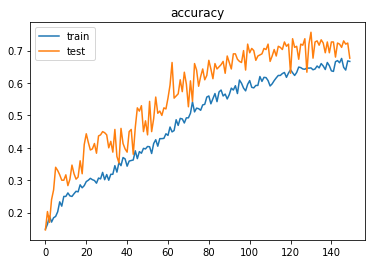

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')

In [22]:
# Training on the whole dataset based on the choosen parameter
batch_size = 32

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=.2, 
                             height_shift_range=.2,vertical_flip=True,
                             fill_mode='nearest',horizontal_flip=True,zoom_range=0.1,shear_range = 0.2 )

# fit parameters from data
datagen.fit(train_x)

#test_model --> based on the hypertuned parameters, we call the model
history = test_model.fit_generator(datagen.flow(train_x, train_y , batch_size=batch_size),
#                         steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=120
#                         validation_data=(X_validation, y_validation)#,callbacks=[early_stopping] 
                             )

Epoch 1/120
47/47 [==============================] - 1s 16ms/step - loss: 0.9202 - accuracy: 0.6847
Epoch 2/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9440 - accuracy: 0.6567
Epoch 3/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9442 - accuracy: 0.6593
Epoch 4/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9381 - accuracy: 0.6640
Epoch 5/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9277 - accuracy: 0.6753
Epoch 6/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9549 - accuracy: 0.6473
Epoch 7/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9187 - accuracy: 0.6593
Epoch 8/120
47/47 [==============================] - 1s 13ms/step - loss: 0.9211 - accuracy: 0.6667
Epoch 9/120
47/47 [==============================] - 1s 14ms/step - loss: 0.9048 - accuracy: 0.6913
Epoch 10/120
47/47 [==============================] - 1s 14ms/step - loss: 0.9158 - accuracy: 0.6587

47/47 [==============================] - 1s 15ms/step - loss: 0.7318 - accuracy: 0.7407
Epoch 83/120
47/47 [==============================] - 1s 13ms/step - loss: 0.7274 - accuracy: 0.7467
Epoch 84/120
47/47 [==============================] - 1s 13ms/step - loss: 0.7341 - accuracy: 0.7507
Epoch 85/120
47/47 [==============================] - 1s 22ms/step - loss: 0.7081 - accuracy: 0.7547
Epoch 86/120
47/47 [==============================] - 1s 14ms/step - loss: 0.7289 - accuracy: 0.7620
Epoch 87/120
47/47 [==============================] - 1s 13ms/step - loss: 0.7158 - accuracy: 0.7520
Epoch 88/120
47/47 [==============================] - 1s 14ms/step - loss: 0.6982 - accuracy: 0.7700
Epoch 89/120
47/47 [==============================] - 1s 13ms/step - loss: 0.6521 - accuracy: 0.7660
Epoch 90/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7128 - accuracy: 0.7593
Epoch 91/120
47/47 [==============================] - 1s 13ms/step - loss: 0.7107 - accuracy: 0.7647
Epo

In [30]:
#Normalizing the values of the test data
test_x=test_x/255.0

#Reshaping the data based on the training set shape
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)

# using the predict function and taking the argmax to the class value
y_pred = test_model.predict(test_x)
pred_label = np.argmax(y_pred, axis=-1)
pred_label.shape

(60000,)

In [31]:
#Writing the result to the submission file
import pandas as pd
i=list(range(0,len(pred_label)))
my_submission = pd.DataFrame({'Id': i, 'Category': pred_label})
my_submission.to_csv('submission11.csv', index=False)

In [32]:
pred_label[0:100]

array([2, 2, 4, 0, 4, 2, 2, 4, 5, 0, 3, 1, 1, 1, 5, 3, 2, 3, 1, 3, 0, 5,
       4, 2, 3, 2, 5, 1, 0, 5, 2, 5, 5, 2, 5, 1, 5, 0, 0, 5, 5, 1, 0, 3,
       0, 1, 2, 5, 2, 2, 0, 3, 1, 4, 2, 5, 2, 3, 2, 5, 1, 3, 3, 3, 2, 1,
       0, 1, 5, 0, 0, 4, 1, 3, 0, 5, 2, 3, 3, 5, 5, 2, 4, 2, 5, 2, 0, 3,
       5, 5, 0, 4, 1, 3, 2, 3, 4, 1, 0, 5])